# Exploração de Texto nos *tweets* que citam a Neoenergia Coelba

## Bibliotecas

In [1]:
import os
from collections import Counter

# Tratamento de dados:
import numpy as np
import pandas as pd
import ast
from pandas.io.json import json_normalize
import json

# Visualização dos gráficos:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# Mineração de texto:

## Corpus:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

## Nuvem de palavras:
from wordcloud import WordCloud, ImageColorGenerator

## Distribuição de frequências:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

## N-Gramas:
from nltk.util import ngrams 
from collections import Counter
import functools

# Análise de Sentimentos:

## Modelos:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Métricas:
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score, GridSearchCV, KFold, RepeatedStratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Modelagem de Tópicos:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to C:\Users\Isabella
[nltk_data]     Calfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Definições de Projeto

In [2]:
# Salvamento de imagens:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "imagens")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [3]:
# Stopwords
stop_words=stopwords.words('portuguese')
new_stopwords=['neoenergia','coelba','rt','aqui','viu','tudo','pq','pra','dm','app','site','whatsapp','link','quase','todo',
'pode','vou','vai','veio','ter','alguma','fez','sobre','vem','deu','via','através','voce','sabia','notif','sao','ate','https'] # avaliar: sms, nunca, hora
stop_words.extend(new_stopwords)

## Carga dos Tweets

In [4]:
# Leitura do Arquivo:
df = pd.read_csv('apoio/coelba.csv')

In [5]:
# Conversão de campos:
df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at']=df['created_at'].dt.tz_convert('America/Fortaleza').dt.tz_localize(None) #Remover timezone

In [6]:
# Inclusão de campos:

## Tamanho do tweet:
df['len'] = df['text'].str.replace('\n','')
df['len'] = df['len'].str.len()
df['word_count'] = df['text'].str.count(' ') + 1

## Função para transformar json em coluna:
def expand(chosen_column, join_id_column, desired_column_name, space):
    dictionary = []
    for i,k in zip(chosen_column,join_id_column):
        if i:
            if space == True:
                i = i.replace(" ", "")
            i = json.loads(i)
            dict1 = {desired_column_name: k }
            new_dict = {**dict1, **i}
            dictionary.append(new_dict)
    return pd.DataFrame(dictionary)

## Localização:
geo_list = df[df['geo'].notnull()]['geo'].tolist()
id_list = df[df['geo'].notnull()]['id'].tolist()
df_geo = expand(geo_list,id_list,'id_tweet',False)
df_geo=df_geo.rename(columns={'id':'id_loc','id_tweet':'id','geo':'coords','name':'city_name'})
df=df.merge(df_geo, how='left', on='id')


## Hashtags:
def find_tags(row_string):
    tags = [x for x in row_string if x.startswith('#')]
    return tags

df['tags'] = df['text'].str.replace('\n#',' #')
df['tags'] = df['tags'].str.split(' ')
df['tags'] = df['tags'].apply(lambda row : find_tags(row))
df['tags'] = df['tags'].apply(lambda x : str(x).replace('#', '').replace('\\n', ',').replace('\\', '').replace("'", ""))

## Usuários mencionados:
def find_users(row_string):
    tags = [x for x in row_string if x.startswith('@')]
    return tags

df['users'] = df['text'].str.replace('\n@',' @')
df['users'] = df['users'].str.split(' ')
df['users'] = df['users'].apply(lambda row : find_users(row))
df['users'] = df['users'].apply(lambda x : str(x).replace('@', '').replace('\\n', ',').replace('\\', '').replace("'", ""))

In [7]:
# Exclusão de campos desnecessários
df = df.drop(columns={'id_loc','place_type','country_code','in_reply_to_user_id','referenced_tweets'})

In [32]:
# Dados do df:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13559 entries, 0 to 13558
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          13559 non-null  int64         
 1   text        13559 non-null  object        
 2   created_at  13559 non-null  datetime64[ns]
 3   author_id   13559 non-null  int64         
 4   lang        13559 non-null  object        
 5   author      13559 non-null  object        
 6   entities    10323 non-null  object        
 7   media       1302 non-null   object        
 8   geo         313 non-null    object        
 9   len         13559 non-null  int64         
 10  word_count  13559 non-null  int64         
 11  coords      313 non-null    object        
 12  country     313 non-null    object        
 13  full_name   313 non-null    object        
 14  city_name   313 non-null    object        
 15  tags        13559 non-null  object        
 16  users       13559 non-

In [33]:
df.describe()

,id,author_id,len,word_count
count,1.355900e+04,1.355900e+04,13559.000000,13559.000000
mean,1.450918e+18,5.814911e+17,123.674976,19.812154
std,5.967558e+16,5.959562e+17,76.143267,12.562617
min,1.344862e+18,3.493611e+06,6.000000,1.000000
25%,1.397706e+18,3.888347e+08,65.000000,10.000000
50%,1.457846e+18,7.066754e+17,110.000000,17.000000
75%,1.495771e+18,1.192869e+18,152.000000,25.000000
max,1.563293e+18,1.555890e+18,428.000000,81.000000


In [8]:
# Remoção de usuário (ver sessão de autores):
df = df[df['author_id'] != 2873781071]

In [9]:
# Pré processamento dos Tweets para Mineração de Texto:
df['text_process'] = df['text'].astype(str).str.lower() 
df['tag_process']=df['tags'].astype(str).str.lower() 
df['user_process']=df['users'].astype(str).str.lower() 

# Remover acentos:
df['text_process']=df['text_process'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['tag_process']=df['tag_process'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['user_process']=df['user_process'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Remover urls:
df['text_process']=df['text_process'].replace(to_replace=r'http\S+|www\S+|https\S+', regex=True, value='')

# Remover @ e #:
df['text_process']=df['text_process'].replace(to_replace=r'\@\w+|\#', regex=True, value='')

# Transformar palavras:
df['text_process']=df['text_process'].replace(to_replace='coelb ', value='coelba')
df['text_process']=df['text_process'].replace(to_replace='notif ', value='notifica')
df['user_process']=df['user_process'].replace(to_replace=' ', value='')

# Selecionar apenas palavras e números:
regexp = RegexpTokenizer('\w+')
df['text_token']=df['text_process'].apply(regexp.tokenize)
df['tag_token']=df['tag_process'].apply(regexp.tokenize)
df['user_token']=df['user_process'].apply(regexp.tokenize)

# Stopwords:
df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stop_words])
df['tag_token'] = df['tag_token'].apply(lambda x: [item for item in x if item not in stop_words])
df['user_token'] = df['user_token'].apply(lambda x: [item for item in x if item not in stop_words])

# Remoção de palavras pouco frequentes (-2x):
df['text_token'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df['tag_token'] = df['tag_token'].apply(lambda x: ' '.join([item for item in x if len(item)>0]))
df['user_token'] = df['user_token'].apply(lambda x: ' '.join([item for item in x if len(item)>0]))

In [10]:
# Lista de palavras, usuários e hashtags

## Palavras:
all_words=''
all_words = ' '.join([word for word in df['text_token']])

## Tags:
all_tags=''
all_tags = ' '.join([tag for tag in df['tag_token']])

## Usuários:
all_users=''
all_users = ' '.join([user for user in df['user_token']])

## Exploração dos Tweets

### Autores

In [ ]:
# Criação do DataFrame de autores:
df_autores=pd.DataFrame(df.groupby(by='author_id')['id'].count()).reset_index(level=0)
df_autores.describe()

In [ ]:
# Identificando e removendo o usuário da empresa:
#df_autores[df_autores['id'] > 100] # Identificar autores que falam muito
#df_autores = df_autores[df_autores['author_id'] != 2873781071]

In [ ]:
# DataFrame para quantidade de usuários por Tweet:
df_autores_tweets=pd.DataFrame(df_autores.groupby(by='id')['author_id'].count()).reset_index(level=0)
df_autores_tweets.head()

In [ ]:
# Divisão dos autores:
## Todos os autores:
plt.subplots(figsize=(15, 7))
ax=sns.barplot(data=df_autores_tweets, x='id', y='author_id', color='gray')
sns.despine(left=True,bottom=False)
ax.axes.yaxis.set_ticklabels([])
ax.set_xlabel('Qtd. Tweets', fontsize=14)
ax.set_ylabel('Qtd. Usuários', fontsize=14)
ax.set_title('Tweets por usuário', fontsize=16)
sns.set_style('darkgrid')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues], fontsize=12)
plt.savefig(os.path.join(IMAGES_PATH, 'autores.png'), bbox_inches='tight', pad_inches = 0)
## Com mais de uma postagem:
plt.subplots(figsize=(15, 7))
ax=sns.histplot(data=df_autores_tweets[df_autores_tweets['id'] > 3], x='id', color='gray')
sns.despine(left=True,bottom=False)
ax.set(xlabel='Qtd. Tweets', ylabel='Qtd. Usuários', title='Usuários com mais de 3 tweets')
ax.axes.yaxis.set_ticklabels([])
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
plt.savefig(os.path.join(IMAGES_PATH, 'maiores-autores.png'))

In [ ]:
df_autores.sort_values(by='id', ascending=False).head()

In [ ]:
df[df['author_id']== 1000490236881797121][['text','created_at','city_name']].head(80)

### Datas

In [ ]:
# Df tweets dia:
df_tt = df[['text','created_at','id']]
df_tt['dt'] = df_tt['created_at'].dt.date
df_tt_resumo=pd.DataFrame(df.groupby(by=df_tt['dt'])['id'].count()).reset_index()
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.lineplot(data=df_tt_resumo, x='dt', y='id', color='gray')
ax.set_xlabel('Dia', fontsize=14)
ax.set_ylabel('Qtd. Tweets', fontsize=14)
ax.set_title('Tweets gerados por dia', fontsize=16)
plt.savefig(os.path.join(IMAGES_PATH, 'tweets-dia.png'), bbox_inches='tight', pad_inches = 0)

In [ ]:

df_tt['dt'] =  pd.to_datetime(df_tt['dt'])
df_tt_resumo.sort_values(by='id',ascending=False).head()

In [ ]:
df_tt[df_tt['dt'] == '2021-09-26'].head(15)

In [ ]:
# Tweets x Dia da Semana:
df_weekday=pd.DataFrame({'weekday':[0,1,2,3,4,5,6], 'name':['Segunda-Feira','Terça-Feira','Quarta-Feira','Quinta-Feira','Sexta-Feira','Sábado','Domingo']})
df_dt=pd.DataFrame(df.groupby(by=df['created_at'].dt.dayofweek)['id'].count()).reset_index(level=0).rename(columns={'created_at':'weekday','id':'qtd'})
df_dt=pd.merge(df_dt, df_weekday, how='left', on='weekday')
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.lineplot(data=df_dt, x='name', y='qtd', color='gray')
ax.set(ylim=(0,2200))
ax.set_xlabel('Dia da semana', fontsize=14)
ax.set_ylabel('Qtd. Tweets', fontsize=14)
ax.set_title('Tweets gerados por dia da semana', fontsize=16)
plt.savefig(os.path.join(IMAGES_PATH, 'dia-da-semana.png'), bbox_inches='tight', pad_inches = 0)


In [ ]:
# Tweets x Hora do Dia
df_dt=pd.DataFrame(df.groupby(by=df['created_at'].dt.hour)['id'].count()).reset_index(level=0).rename(columns={'created_at':'hour','id':'qtd'})
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.barplot(data=df_dt, x='hour', y='qtd', color='gray')
ax.set_xlabel('Hora do dia', fontsize=14)
ax.set_ylabel('Qtd. Tweets', fontsize=14)
ax.set_title('Tweets gerados por hora do dia', fontsize=16)
sns.despine(left=True,bottom=False)
ax.axes.yaxis.set_ticklabels([])
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
plt.savefig(os.path.join(IMAGES_PATH, 'hora-do-dia.png'), bbox_inches='tight', pad_inches = 0)
plt.show()

In [ ]:
# Tamanho dos tweets x hora do dia
df_dt=df[['created_at','len']].reset_index(level=0)
df_dt['hour']=df_dt['created_at'].dt.hour
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.boxplot(x='hour', y='len', data=df_dt, color='gray')
ax.set(xlabel='Hora do dia', ylabel='Tamanho dos tweets gerados', title='Tamanho dos tweets gerados por hora do dia')
plt.savefig(os.path.join(IMAGES_PATH, 'hora-do-dia-tamanho-tweet.png'))
plt.show()


In [ ]:
# Quantidade de palavras x hora do dia
df_dt=df[['created_at','word_count']].reset_index(level=0)
df_dt['hour']=df_dt['created_at'].dt.hour
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.boxplot(x='hour', y='word_count', data=df_dt, color='gray')
ax.set(xlabel='Hora do dia', ylabel='Qtd. de palavras no tweet', title='Quantidade de palavras no tweet por hora do dia')
plt.savefig(os.path.join(IMAGES_PATH, 'hora-do-dia-qtd-palavras.png'))
plt.show()


In [ ]:
pd.set_option('display.max_colwidth', None)
df[(df['created_at'].dt.hour == 13) & (df['word_count'] > 60)][['text', 'author_id', 'word_count']]

In [ ]:
# Tweets por dia do mês
df_dt=df[['created_at','id']].reset_index(level=0)
df_dt['day']=df_dt['created_at'].dt.day
df_dt=pd.DataFrame(df.groupby(by=df['created_at'].dt.day)['id'].count()).reset_index(level=0).rename(columns={'created_at':'day','id':'qtd'})
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.barplot(data=df_dt, x='day', y='qtd', color='gray')
ax.set_xlabel('Dia do mês', fontsize=14)
ax.set_ylabel('Qtd. Tweets', fontsize=14)
ax.set_title('Tweets gerados por dia do mês', fontsize=16)
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
sns.despine(left=True,bottom=False)
plt.savefig(os.path.join(IMAGES_PATH, 'dia-do-mes.png'), bbox_inches='tight', pad_inches = 0)
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)
df[df['created_at'].dt.day == 12][['text', 'author_id', 'word_count']].head(30)

In [ ]:
# Evolução dos Tweets por dia e hora na semana:
df_dt=df
df_dt['hour']=df['created_at'].dt.hour
df_dt['weekday']=df['created_at'].dt.weekday
df_dt=pd.DataFrame(df_dt.groupby([df_dt['hour'], df_dt['weekday']])['id'].count()).reset_index()
df_dt=pd.merge(df_dt, df_weekday, how='left', on='weekday')
df_dt['day_hour']=df_dt['name'].astype(str) + ' ' + df_dt['hour'].astype(str) + 'h'
## Plotagem do gráfico
config={'color': ['gray']}
col_order=['Segunda-Feira','Terça-Feira','Quarta-Feira','Quinta-Feira','Sexta-Feira','Sábado','Domingo']
sns.set_style('darkgrid')
ax = sns.FacetGrid(df_dt, col='name', col_wrap=3, height=3, col_order=col_order, aspect=1, hue_kws=config)
ax.map(sns.lineplot, 'hour', 'id')
ax.set_titles(col_template='{col_name}')
ax.set_axis_labels(x_var='Hora da postagem', y_var='Qtd. Tweets gerados')
ax.set(xticks=[0,2,4,6,8,10,12,14,16,18,20,23])
ax.savefig(os.path.join(IMAGES_PATH, 'dia-hora-da-semana.png'), bbox_inches='tight', pad_inches = 0)

In [ ]:
pd.set_option('display.max_colwidth', None)
df[(df['created_at'].dt.dayofweek == 5) & (df['created_at'].dt.hour == 13)][['text', 'author_id', 'word_count']].head(25)

### Autores x Datas

In [ ]:
# Exploração dos usuários que postam entre 21h e 3h
df_madrugada=df[(df['created_at'].dt.hour > 21) | (df['created_at'].dt.hour < 3)][['author_id','text','created_at','id','city_name']]
df_autores_madrugada=pd.DataFrame(df_madrugada.groupby(by='author_id')['id'].count()).reset_index(level=0)
df_autores_madrugada['id'].describe()

In [ ]:
# Principais autores que postam na madrugada:
df_autores_madrugada[df_autores_madrugada['id'] > 9].sort_values(by='id',ascending=False)
# 1000490236881797121 - Consumidor
# 827290961252384770 - Consumidor

In [ ]:
df_madrugada[df_madrugada['author_id']== 1000490236881797121] 

### Localização

In [ ]:
# Tweets x Município
df_loc=pd.DataFrame(df.groupby(by=df['city_name'])['id'].count()).reset_index(level=0).sort_values(by='id', ascending=False)
df_loc['perc']=(df_loc['id']/df_loc['id'].sum())*100

## Valores brutos:
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.barplot(data=df_loc[df_loc['id'] > 1], x='id', y='city_name', color='gray')
sns.despine(left=True,bottom=False)
ax.set(xlabel='Qtd. Tweets gerados', ylabel='Municípios', title='Tweets gerados por município (> 1 tweet)')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
plt.savefig(os.path.join(IMAGES_PATH, 'locais-tweets.png'))
plt.show()

## Valores relativos:
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.barplot(data=df_loc[df_loc['perc'] > 0.5], x='perc', y='city_name', color='gray')
sns.despine(left=True,bottom=False)
ax.set(xlabel='% Tweets gerados', ylabel='Municípios', title='Tweets gerados por município (%)')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.1f}' for x in container.datavalues])
plt.savefig(os.path.join(IMAGES_PATH, 'locais-tweets-perc.png'))
plt.show()

In [ ]:
## Percentual da população por município
df_pop = pd.read_csv('pop-bahia-2010.csv', encoding='latin1', sep=';')
df_pop = df_pop.rename(columns={'municipio':'city_name'})
df_pop = df_pop[['city_name','populacao']].sort_values(by='populacao',ascending=False)
df_pop['perc']=(df_pop['populacao']/df_pop['populacao'].sum())*100

## Gráfico:
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.barplot(data=df_pop[df_pop['perc'] > 0.5], x='perc', y='city_name', color='gray')
sns.despine(left=True,bottom=False)
ax.set(xlabel='% Tweets gerados', ylabel='Municípios', title='População por município da Bahia (%)')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.1f}' for x in container.datavalues])
plt.savefig(os.path.join(IMAGES_PATH, 'pop-municipio-perc.png'))
plt.show()

In [ ]:
# União dos dfs de população e tweets
df_comp=df_loc.merge(df_pop, how='left', on='city_name').rename(columns={'perc_x':'% tweets','perc_y':'% população'}).sort_values(by='% população',ascending=False)

## Gráfico:
ax=df_comp[(df_comp['% tweets'] > 0.5) & (df_comp['city_name'] != 'Salvador')].plot(x='city_name', y=['% população','% tweets'], 
kind='bar', figsize=(15,7), color=['black','gray'])
ax.set(xlabel='% Tweets gerados', ylabel='Municípios', title='População por município da Bahia (%)')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.1f}' for x in container.datavalues])
ax.axes.yaxis.set_ticklabels([])
plt.savefig(os.path.join(IMAGES_PATH, 'tweets-pop-municipio-perc.png'))
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)
df[df['city_name']== 'Ilhéus'][['text','created_at']].head(10)

## Relação entre variáveis

### Bandeiras tarifárias x Qtd. Tweets

In [ ]:
# Tweets x Mês e Ano
df_dt=pd.DataFrame(df.groupby(by=df['created_at'].dt.to_period('M'))['id'].count()).reset_index(level=0).rename(columns={'created_at':'period','id':'qtd'})

## Bandeiras tarifárias:
verde=[16,17,18,19]
amarela=[0,1,2,3]
vermelhai=[4]
vermelhaii=[5,6,7]
escassez=[8,9,10,11,12,13,14,15]
df_dt.loc[verde,['bandeira']]='Verde'
df_dt.loc[amarela,['bandeira']]='Amarela'
df_dt.loc[vermelhai,['bandeira']]='Vermelha I'
df_dt.loc[vermelhaii,['bandeira']]='Vermelha II'
df_dt.loc[escassez,['bandeira']]='Escassez Hídrica'
df_dt.loc[verde,['bandeira_class']]=0
df_dt.loc[amarela,['bandeira_class']]=1
df_dt.loc[vermelhai,['bandeira_class']]=2
df_dt.loc[vermelhaii,['bandeira_class']]=3
df_dt.loc[escassez,['bandeira_class']]=4

## Gráfico:
palette={'Verde':'green','Amarela': 'yellow', 'Vermelha I':'red', 'Vermelha II':'darkred', 'Escassez Hídrica':'black'}
plt.subplots(figsize=(15, 7))
ax=sns.barplot(data=df_dt, x='period', y='qtd', palette=palette, hue='bandeira')
ax.set_xlabel('Mês e ano', fontsize=14)
ax.set_ylabel('Qtd. Tweets', fontsize=14)
ax.set_title('Tweets gerados por ano e mês x Bandeira tarifária', fontsize=16)
sns.set_style('darkgrid')
sns.despine(left=True,bottom=False)
ax.axes.yaxis.set_ticklabels([])
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues], fontsize=12)
plt.savefig(os.path.join(IMAGES_PATH, 'periodo-do-ano-tweets.png'), bbox_inches='tight', pad_inches = 0)
plt.show()

### Bandeiras tarifárias x Qtd Tweets x Indicadores de Qualidade

In [ ]:
## Tweets e Bandeiras - Célula anterior

## Indicadores de Qualidade
df_qualidade = pd.read_csv('dados-abertos/indicadores-continuidade.csv', delimiter=';').rename(columns={'periodo':'period'})
df_qualidade['period'] = df_qualidade['period'].apply(pd.to_datetime).dt.to_period('M')

## Reclamações Ouvidoria
df_ouvidoria = pd.read_csv('dados-abertos/reclamacoes-n1e2-distribuidoras.csv', delimiter = ';', encoding='latin1')
### Filtros no dt para buscar apenas reclamações da Coelba na Bahia a partir de janeiro de 2021 e que não sejam de busca por informações
df_ouvidoria = df_ouvidoria[(df_ouvidoria['SigUF'] == 'BA') & (df_ouvidoria['SigAgente'] == 'COELBA') & (df_ouvidoria['DatReferencia'] >= '2021-01-01') & (df_ouvidoria['CodTipoReclamacao'] != 19)]
df_ouvidoria['NumPrazoMedioSolucao'] = df_ouvidoria['NumPrazoMedioSolucao'].str.replace(',','.').astype(float)
df_ouvidoria['period'] = df_ouvidoria['DatReferencia'].apply(pd.to_datetime).dt.to_period('M')
df_ouvidoria_tipo=pd.DataFrame(df_ouvidoria.groupby(['NomCanalReclamacao','DescReclamacao','period'])['QtdReclamacoesRecebidas'].sum()).reset_index()
df_ouvidoria_resumo=pd.DataFrame(df_ouvidoria.groupby(['period'])['QtdReclamacoesRecebidas'].sum()).reset_index()

## Indicadores de Atendimento
df_atendimento = pd.read_csv('dados-abertos/dados-tma-coelba.csv', delimiter = ',', encoding='latin1')
df_atendimento['VlrIndiceEnviado'] = df_atendimento['VlrIndiceEnviado'].str.replace(',','.').astype(float)
df_atendimento['NumPeriodoIndice'] = df_atendimento['NumPeriodoIndice'].apply(lambda s: '0' + str(int(s)) if s < 10 else str(int(s)))
df_atendimento['period'] =  df_atendimento['AnoIndice'].astype(str) +  '-' + df_atendimento['NumPeriodoIndice']
df_atendimento = df_atendimento[(df_atendimento['SigIndicador'] != 'NDIACRI') & (df_atendimento['SigIndicador'] != 'VLCLACRI')]
df_atendimento=pd.DataFrame(df_atendimento.groupby(['period','SigIndicador'])['VlrIndiceEnviado'].mean()).reset_index()
df_atendimento = pd.pivot_table(df_atendimento, values='VlrIndiceEnviado', columns=['SigIndicador'], index='period').reset_index()
df_atendimento['period'] = df_atendimento['period'].apply(pd.to_datetime).dt.to_period('M')

In [ ]:
## Correlações:
df_rel = df_dt.rename(columns={'qtd':'qtd_tweets'})
df_rel = df_rel.merge(df_qualidade, how='left', on='period')
df_rel = df_rel.merge(df_ouvidoria_resumo, how='left', on='period')
df_rel = df_rel.merge(df_atendimento, how='left', on='period')
#df_rel.head()
correlation = df_rel.corr()
plt.subplots(figsize=(15, 7))
sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.2, cbar=False)
plt.savefig(os.path.join(IMAGES_PATH, 'correlacao-entre-variaveis.png'))
plt.show()

In [ ]:
# Tweets x Reclamações
df_test=df_rel[['period','qtd_tweets','QtdReclamacoesRecebidas']].rename(columns={'qtd_tweets': 'Qtd. Tweets'})
df_test['Qtd. Reclamacoes x 100'] = round(df_test['QtdReclamacoesRecebidas']/100,0)

## Gráfico:
ax=df_test.plot(x='period', y=['Qtd. Reclamacoes x 100','Qtd. Tweets'], 
kind='line', figsize=(15,7), color=['black','gray'])
sns.set_style('darkgrid')
ax.set_xlabel('Período', fontsize=14)
ax.set_ylabel('Qtd. Tweets', fontsize=14)
ax.set_title('Tweets e Reclamações ANEEL gerados por mês e ano', fontsize=16)
plt.savefig(os.path.join(IMAGES_PATH, 'tweets-reclamacoes-mes.png'), bbox_inches='tight', pad_inches = 0)
plt.show()

In [ ]:
# Tweets x Reclamações
df_test=df_rel[['period','qtd_tweets','dec_puro']]
df_test['DEC Puro (min)'] = round(df_test['dec_puro']*60,0)
df_test['Qtd. Tweets'] = round(df_test['qtd_tweets'],0)

## Gráfico:
ax=df_test.plot(x='period', y=['DEC Puro (min)','Qtd. Tweets'], 
kind='line', figsize=(15,7), color=['black','gray'])
sns.set_style('darkgrid')
#plt.savefig(os.path.join(IMAGES_PATH, 'tweets-reclamacoes-mes.eps'))
plt.show()

## Mineração de Texto

### Funções

In [ ]:
# Wordcloud
def print_wordcloud(qtd_words, words_list, name):
    wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=1, 
                     max_words=qtd_words,
                     background_color='white',
                     colormap='plasma',
                     repeat=False,
                     collocations=False, #Não unir palavras
                     max_font_size=100).generate(words_list)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(os.path.join(IMAGES_PATH, f'nuvem-palavras-{name}.png'), bbox_inches='tight', pad_inches = 0)
    plt.show()

# Distribuição de Frequências:
def print_fd(qtd_words, words_list, name, title):
    words = word_tokenize(words_list)
    fd = FreqDist(words)
    top = fd.most_common(qtd_words)
    fdist = pd.Series(dict(top))

    plt.subplots(figsize=(15, 7))
    sns.set_style('darkgrid')
    ax=sns.barplot(x=fdist.values, y=fdist.index, color='gray')
    sns.despine(left=True,bottom=False)
    ax.set(xlabel='Quantidade de aparições', ylabel='Palavras', title=title)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(title, fontsize=16)
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues], fontsize=12)
    plt.savefig(os.path.join(IMAGES_PATH, f'palavras-mais-frequentes-{name}.png'), bbox_inches='tight', pad_inches = 0)
    plt.show()

# Usuários por tipo
def users_by_type(userType, qtd, df_users_fd):
    data=df_users_fd[df_users_fd['user_type'] == userType].sort_values(by='frequency', ascending=False).head(qtd)
    plt.subplots(figsize=(15, 7))
    sns.set_style('darkgrid')
    ax=sns.barplot(data=data, x='word', y='frequency', color='gray')
    sns.despine(left=True,bottom=False)
    ax.set(xlabel=f'Usuário do tipo {userType}', ylabel='Qtd. menções', title=f'Quantidade de menções por usuário do tipo {userType}')
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
    plt.savefig(os.path.join(IMAGES_PATH, f'{qtd}-usuarios-mais-mencionados-{userType}-tweets.png'), bbox_inches='tight', pad_inches = 0)
    return plt.show()

In [ ]:
# N-gramas
def n_grams(qtd, column_name, limit):
    df[column_name] = df['text_token'].apply(lambda x: list(ngrams(x.split(), qtd)))
    bigrams_words = df[column_name]
    l = functools.reduce(lambda x, y: list(x)+list(y), zip(bigrams_words))
    flatten = [item for sublist in l for item in sublist]
    counts = Counter(flatten).most_common()
    df_ngrams = pd.DataFrame.from_records(counts, columns=['Phrase', 'Count'])
    df_ngrams['Phrase']= df_ngrams['Phrase'].apply(lambda x: ' '.join([w for w in x]))
    df2 = df_ngrams.nlargest(columns='Count', n = limit) 
    plt.figure(figsize=(5,10))
    sns.set_style('darkgrid')
    ax = sns.barplot(data=df2, x= 'Count', y = 'Phrase',color='gray')
    sns.despine(left=True,bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.set(xlabel='Qtd. aparições', ylabel=column_name, title=f'{column_name} mais frequentes')
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
    plt.savefig(os.path.join(IMAGES_PATH, f'n-grams-{column_name}-mais-frequentes.png'))
    plt.show()

### Nuvem de Palavras dos Tweets

In [ ]:
# WordCloud:
print_wordcloud(50,all_words,'geral')

In [ ]:
## Busca de palavras nas frases
df.loc[df['text_process'].str.contains('eletrocutada', case=False)][['text','text_process']]

**Notas sobre as palavras**

* *lear:* Tipo de arara azul que estava morrendo eletrocutada na rede da distribuidora. Foram feitas várias reportagens sobre a situação.
* *eletrocutada:* Muitos comentários sobre as araras azuis, mas alguns sobre acidentes envolvendo a rede elétrica.

### Distribuição de Frequências dos Tweets

In [ ]:
# Distribuição de Frequências:
print_fd(20, all_words, 'geral', 'Palavras que mais aparecem nos tweets')

### Hashtags

In [ ]:
# WordCloud:
print_wordcloud(50,all_tags,'tags')

In [ ]:
# Distribuição de Frequências:
print_fd(20, all_tags, 'hashtags', 'Hashtags que mais aparecem nos tweets')

In [ ]:
## Busca de hashtags nas frases
df.loc[df['tag_process'].str.contains('co', case=False)][['text','tag_process']]

### Usuários mencionados

In [ ]:
# WordCloud:
print_wordcloud(30,all_users,'users-mentioned')

In [ ]:
# Distribuição de Frequências:
print_fd(20, all_users, 'usuarios', 'Usuários que mais aparecem nos tweets')

In [ ]:
words = word_tokenize(all_users)
fd_users = FreqDist(words)
df_users_fd=pd.DataFrame(fd_users.items(), columns=['word', 'frequency'])
df_users_fd=df_users_fd[df_users_fd['frequency'] > 10].sort_values(by='frequency',ascending=False)

## Classificação:
company=[1679,15,25,2021]
midia=[104,375,555,1005,808,342,168,1700,173,1029,242,374,1314]
gov=[246,218,32,95,1905]
df_users_fd.loc[company,['user_type']]='Companhia'
df_users_fd.loc[midia,['user_type']]='Mídia'
df_users_fd.loc[gov,['user_type']]='Governo'
df_users_fd['user_type']=df_users_fd['user_type'].fillna('Outros')

# Tweets x Usuário mencionado
df_users_fd_resume=pd.DataFrame(df_users_fd.groupby(by=df_users_fd['user_type'])['frequency'].sum()).reset_index(level=0).sort_values(by='frequency', ascending=False)
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.barplot(data=df_users_fd_resume, x='user_type', y='frequency', color='gray')
sns.despine(left=True,bottom=False)
ax.set(xlabel='Tipo de usuário', ylabel='Qtd. menções aos usuários', title='Quantidade de menções por tipo de usuário')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
plt.savefig(os.path.join(IMAGES_PATH, 'tipo-usuario-mencionado-tweets.png'))
plt.show()

In [ ]:
# Usuários mais mencionados por tipo
users_by_type('Governo',10,df_users_fd)

In [ ]:
# Df Araras:
df_araras=df[df['text_token'].str.contains('araras')][['text','created_at','id']]
df_araras['dt'] = df_araras['created_at'].dt.date
df_araras_resumo=pd.DataFrame(df_araras.groupby(by=df_araras['dt'])['id'].count()).reset_index(level=0)
df_araras_resumo.head(30)

### Nuvens de palavras específicas

In [ ]:
# Bandeiras x tweets
df_test = df[['text_token','created_at']]
df_test['period']=df_test['created_at'].dt.to_period('M')
df_test = pd.merge(df_test, df_dt, on='period', how='left')
df_test.head()

In [ ]:
## Palavras:
words_cloud=''
### Palavras dentro do tweet:
#words_cloud = ' '.join([word for word in df[(df['text_token'].str.contains('conta') & df['bandeira'])]['text_token']])
#words_cloud = ' '.join([word for word in df_test[(df['user_token'].str.contains('aneel_govbr'))]['text_token']])
words_cloud = ' '.join([word for word in df[(df['user_token'].str.contains('salvador'))]['text_token']])
print_wordcloud(30,words_cloud,'termo-salvador')

In [ ]:
df[(df['text_token'].str.contains('conta')) & ((df['text_token'].str.contains('dulce')) | (df['text_token'].str.contains('irma')))][['text','city_name']].head(20)

### Bigramas

In [ ]:
n_grams(2,'Bigramas',20)

### Trigramas

In [ ]:
n_grams(3,'Trigramas',20)

### 4-Gramas

In [ ]:
n_grams(4,'Quadrigramas',20)

## Modelagem de Tópicos:

### Funções

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

### Dados:

In [13]:
data = df.text_token.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1])

[['obra', 'ondina', 'parece', 'romance', 'jorge', 'amado', 'obra', 'fim', 'politica']]


### Formação de N-gramas

In [14]:
# Construir modelos de bigramas e trigramas:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Organizando as frases:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts): # bigramas
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts): #trigramas
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)
data_words_trigrams = make_trigrams(data_words)

### Aplicação do Modelo LDA

In [15]:
# Criando dicionário:
id2word = corpora.Dictionary(data_words_bigrams)

# Criando corpus:
texts = data_words_bigrams

# Frequência dos termos:
corpus = [id2word.doc2bow(text) for text in texts]

# Construindo modelo LDA:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Cálculo da perplexidade: 
print('Perplexidade: ', lda_model.log_perplexity(corpus)) 

# Cálculo da coerência: 
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoerência: ', coherence_lda)                                           

Perplexidade:  -9.065271037524413

Coerência:  0.4413587028003789


In [16]:
# Ver os tópicos montados:
for index, topic in lda_model.show_topics(formatted=False, num_words= 10):
    print('\nTópico: {} \nPalavras: {}'.format(lda_model, [w[0] for w in topic]))


Tópico: LdaModel(num_terms=13712, num_topics=5, decay=0.5, chunksize=100) 
Palavras: ['energia', 'luz', 'dia', 'casa', 'embasa', 'agora', 'ainda', 'mae', 'porra', 'hora']

Tópico: LdaModel(num_terms=13712, num_topics=5, decay=0.5, chunksize=100) 
Palavras: ['nao', 'conta', 'hoje', 'salvador', 'pagar', 'servico', 'covid', 'ficar', 'ajuda', 'fatura']

Tópico: LdaModel(num_terms=13712, num_topics=5, decay=0.5, chunksize=100) 
Palavras: ['eletrica', 'agua', 'rede', 'boa', 'subestacao', 'dias', 'merda', 'sorte', 'bairro', 'daqui']

Tópico: LdaModel(num_terms=13712, num_topics=5, decay=0.5, chunksize=100) 
Palavras: ['poste', 'rua', 'falta', 'anos', 'bom', 'faz', 'mim', 'internet', 'todos', 'acao']

Tópico: LdaModel(num_terms=13712, num_topics=5, decay=0.5, chunksize=100) 
Palavras: ['bahia', 'cara', 'empresa', 'cortar', 'deus', 'video', 'odeio', 'dinheiro', 'verao', 'contra']


In [20]:
# Definindo número de tópicos:
coherence = []
for k in range(10,35):
     Lda = gensim.models.ldamodel.LdaModel
     ldamodel = Lda(corpus, num_topics=k, \
               id2word = id2word, passes=40,\
               iterations=200, chunksize = 10000, random_state=100, eval_every = None)
    
     cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=data_words_bigrams,\
         dictionary=id2word, coherence='c_v')  
     print(f'k: {k} / cv {cm.get_coherence()}') 
     coherence.append((k,cm.get_coherence()))


k: 10 / cv 0.36493131060543826
k: 11 / cv 0.37046049695476974
k: 12 / cv 0.3849890398563239
k: 13 / cv 0.4007619199555086
k: 14 / cv 0.38811989896094595
k: 15 / cv 0.40591112225224457
k: 16 / cv 0.3759368125873144
k: 17 / cv 0.3850939686531942
k: 18 / cv 0.40185422711389984
k: 19 / cv 0.3966143413392584
k: 20 / cv 0.40373103608214345
k: 21 / cv 0.45453033519390323
k: 22 / cv 0.42106293149545065
k: 23 / cv 0.41117107448826773
k: 24 / cv 0.41797716352832454
k: 25 / cv 0.4044568102967298
k: 26 / cv 0.4063299797412456
k: 27 / cv 0.43159765543332906
k: 28 / cv 0.41741680956203275
k: 29 / cv 0.43420953807909446
k: 30 / cv 0.42583391424673883
k: 31 / cv 0.4316674897643519
k: 32 / cv 0.41714901142849825
k: 33 / cv 0.41787339828181774
k: 34 / cv 0.41789877152696275


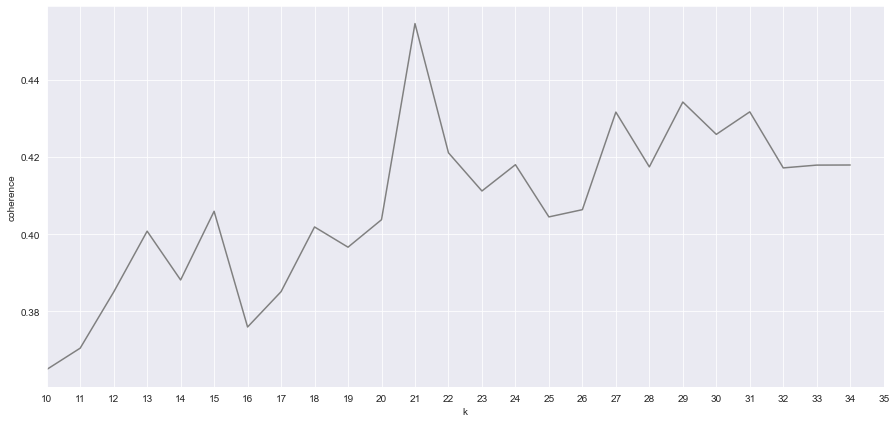

In [22]:
df_coe = pd.DataFrame (coherence, columns = ['k', 'coherence'])
plt.subplots(figsize=(15, 7))
sns.set_style('darkgrid')
ax=sns.lineplot(data=df_coe, x='k', y='coherence', color='gray')
ax.set_xlim(10,35)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [24]:
# Modelo melhorado:
Lda_i = gensim.models.ldamodel.LdaModel
ldamodel_i = Lda_i(corpus, num_topics=21, \
            id2word = id2word, passes=40,\
            iterations=200, chunksize = 10000, eval_every = None)
    
cm = gensim.models.coherencemodel.CoherenceModel(\
    model=ldamodel_i, texts=data_words_bigrams,\
    dictionary=id2word, coherence='c_v')   

# Ver os tópicos montados:
for index, topic in ldamodel_i.show_topics(formatted=False, num_words= 30):
    print('\nTópico: {} \nPalavras: {}'.format(ldamodel_i, [w[0] for w in topic]))


Tópico: LdaModel(num_terms=13712, num_topics=21, decay=0.5, chunksize=10000) 
Palavras: ['cpi', 'nao', 'servicos', 'data', 'bahia', 'servico', 'diz', 'governo', 'alba', 'agencia', 'hoje', 'ameaca', 'assembleia_legislativa', 'sera', 'deputado', 'contra', 'baiano', 'procon', 'deputados', 'aki', 'leia', 'deve', 'retorno', 'certo', 'lucro', 'base', 'pare', 'apos', 'proxima', 'apoio']

Tópico: LdaModel(num_terms=13712, num_topics=21, decay=0.5, chunksize=10000) 
Palavras: ['energia', 'brasil', 'salvador', 'abre', 'trabalho', 'eletrica', 'emprego', 'publica', 'duas', 'estagio', 'vaga', 'responde', 'processo_seletivo', 'quedas', 'aracatu', 'mil', 'importante', 'veja', 'laudostecnicos', 'tarifa_social', 'confira', 'reuniao', 'spda', 'vagas', 'informou', 'faz', 'neoe', 'anuncia', 'acao', 'municipio']

Tópico: LdaModel(num_terms=13712, num_topics=21, decay=0.5, chunksize=10000) 
Palavras: ['energia', 'mae', 'eletrica', 'segunda', 'nao', 'valor', 'milhoes', 'rede', 'dia', 'fatura', 'dois', 'vide

In [25]:
### Melhorando o modelo:

#### Função de coerência:
def compute_coherence_values(corpus, dictionary, k, a, b, text): 
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=21, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

import tqdm
grid = {}
grid['Validation_Set'] = {}
# Parâmetro alpha:
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Parâmetro beta:
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validações
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Execução:
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # Iteração pelo corpus:
    for i in range(len(corpus_sets)):
        # Iteração pelo alpha:
        for a in alpha:
            # Iteração pelo beta:
            for b in beta:
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                k=21, a=a, b=b, text=data_words_bigrams)
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

 11%|█         | 60/540 [52:29<6:59:57, 52.49s/it]


In [26]:
df_lda_model = pd.read_csv('lda_tuning_results.csv')
df_lda_model.sort_values(by='Coherence', ascending=False).head()

,Validation_Set,Topics,Alpha,Beta,Coherence
18,75% Corpus,34,0.9099999999999999,0.9099999999999999,0.568801
17,75% Corpus,34,0.9099999999999999,0.61,0.563734
56,100% Corpus,34,asymmetric,0.31,0.542317
37,100% Corpus,34,0.31,0.61,0.523998
6,75% Corpus,34,0.31,0.31,0.517645


In [28]:
df_co = df_lda_model[('Topics'==21) & (df_lda_model['Validation_Set'] == '100% Corpus')]
df_co.sort_values(by='Coherence', ascending=False)


,Validation_Set,Topics,Alpha,Beta,Coherence


### Trigramas

In [ ]:
# Criando dicionário:
id2word = corpora.Dictionary(data_words_bigrams)

# Criando corpus:
texts = data_words_trigrams

# Frequência dos termos:
corpus = [id2word.doc2bow(text) for text in texts]

# Construindo modelo LDA:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Cálculo da perplexidade: 
print('Perplexidade: ', lda_model.log_perplexity(corpus)) 
print()
# Cálculo da coerência: 
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoerência: ', coherence_lda)   

In [ ]:
# Ver os tópicos montados:
for index, topic in lda_model.show_topics(formatted=False, num_words= 20):
    print('\nTópico: {} \nPalavras: {}'.format(lda_model, [w[0] for w in topic]))

## Análise dos Sentimentos:

### Montagem do conjunto de treino

Considerando que o conjunto de dados contém 12.581 tweets, propõe-se a utilização de 5% do total para classificação no conjunto de treino.

In [ ]:
# Geração da Amostra de Classificação
df_classificacao=pd.DataFrame(df['text'].sample(frac=0.05, random_state=1))
df_classificacao.to_csv('amostra-classificacao.csv', encoding='utf8', index=False)

In [11]:
# Carga do DF após tratamento:
df_classificacao = pd.read_csv('apoio/amostra-classificacao-tratado.csv')
df_classificacao['sentiment_class']=df_classificacao['sentimento']
df_classificacao['topic_class']=df_classificacao['topico']
df_classificacao['sentiment_class']=df_classificacao['sentiment_class'].replace(to_replace='Positivo', value=1)
df_classificacao['sentiment_class']=df_classificacao['sentiment_class'].replace(to_replace='Negativo', value=-1)
df_classificacao['sentiment_class']=df_classificacao['sentiment_class'].replace(to_replace='Neutro', value=0)
df_classificacao['topic_class']=df_classificacao['topic_class'].replace(to_replace='Falta de energia', value=0)
df_classificacao['topic_class']=df_classificacao['topic_class'].replace(to_replace='Corte', value=1)
df_classificacao['topic_class']=df_classificacao['topic_class'].replace(to_replace='Conta', value=2)
df_classificacao['topic_class']=df_classificacao['topic_class'].replace(to_replace='Outros', value=3)
df_classificacao['topic_class']=df_classificacao['topic_class'].replace(to_replace='Notícia', value=4)
df_classificacao['topic_class']=df_classificacao['topic_class'].replace(to_replace='Atendimento', value=3)
df_classificacao['topic_class']=df_classificacao['topic_class'].replace(to_replace='Crítica', value=3)
df_classificacao['topic_class']=df_classificacao['topic_class'].replace(to_replace='Elogio', value=3)
df_classificacao['topic_class']=df_classificacao['topic_class'].replace(to_replace='Telefonia/Internet', value=3)

In [12]:
# Pré processamento dos Tweets:
df_classificacao['text_process'] = df_classificacao['texto'].astype(str).str.lower() 

# Remover acentos:
df_classificacao['text_process']=df_classificacao['text_process'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Remover urls:
df_classificacao['text_process']=df_classificacao['text_process'].replace(to_replace=r'http\S+|www\S+|https\S+', regex=True, value='')

# Remover @ e #:
df_classificacao['text_process']=df_classificacao['text_process'].replace(to_replace=r'\@\w+|\#', regex=True, value='')

# Selecionar apenas palavras e números:
regexp = RegexpTokenizer('\w+')
df_classificacao['text_token']=df_classificacao['text_process'].apply(regexp.tokenize)

# Stopwords:
df_classificacao['text_token'] = df_classificacao['text_token'].apply(lambda x: [item for item in x if item not in stop_words])

# Remoção de palavras pouco frequentes (-1x):
df_classificacao['text_token'] = df_classificacao['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>1]))

In [ ]:
df_classificacao.to_csv('apoio/base-analise-sentimentos.csv')

### Testes de modelos

In [38]:
#Variáveis dos Modelos:
n_folds=30 #Número de folds
cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=5, random_state=1) #Geração do KFold
scoring='accuracy' #Métrica de avaliação principal

In [39]:
# Funções:
def metricas(teste,predito):
    nome={}
    acc=metrics.accuracy_score(teste,predito)
    mcc=metrics.matthews_corrcoef(teste,predito)
    r=metrics.recall_score(teste,predito,average='macro')
    p=metrics.precision_score(teste,predito,average='macro')
    f1=metrics.f1_score(teste,predito,average='macro')
    nome = dict(zip(['acc','mcc','r','p','f1'], [acc,mcc,r,p,f1]))
    return nome

def mc(teste,predito):
    confusion_matrix = pd.crosstab(teste, predito, rownames=['Real'], colnames=['Predito'])
    return confusion_matrix

In [40]:
# Avaliação dos modelos com os conjuntos de treino:
models = []
results = []
names = []
models.append(('Naive Bayes TF', MultinomialNB(), TfidfVectorizer()))
models.append(('Naive Bayes Vetor', MultinomialNB(), CountVectorizer(analyzer='word')))
models.append(('Logistic Regression TF', LogisticRegression(solver='lbfgs'), TfidfVectorizer()))
models.append(('Logistic Regression Vetor', LogisticRegression(solver='lbfgs'), CountVectorizer(analyzer='word')))
models.append(('RandomForest TF', RandomForestClassifier(), TfidfVectorizer()))
models.append(('RandomForest Vetor', RandomForestClassifier(), CountVectorizer(analyzer='word')))
models.append(('SVM TF', SVC(), TfidfVectorizer()))
models.append(('SVM Vetor', SVC(), CountVectorizer(analyzer='word')))

print('Tweets tratados:')
for name, model, vector in models:
    text_counts = vector.fit_transform(df_classificacao['text_token'])
    x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
    cv_results = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

print()
print('Tweets sem tratamento:')
for name, model, vector in models:
    text_counts = vector.fit_transform(df_classificacao['text_process'])
    x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
    cv_results = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Tweets tratados:
Naive Bayes TF: 0.623238 (0.105182)
Naive Bayes Vetor: 0.623810 (0.117807)
Logistic Regression TF: 0.646667 (0.111450)
Logistic Regression Vetor: 0.644667 (0.120095)
RandomForest TF: 0.584635 (0.114181)
RandomForest Vetor: 0.594667 (0.117473)
SVM TF: 0.628698 (0.117932)
SVM Vetor: 0.600635 (0.117284)

Tweets sem tratamento:
Naive Bayes TF: 0.656349 (0.101899)
Naive Bayes Vetor: 0.639143 (0.106364)
Logistic Regression TF: 0.668127 (0.110726)
Logistic Regression Vetor: 0.653111 (0.106765)
RandomForest TF: 0.616857 (0.119581)
RandomForest Vetor: 0.621111 (0.115299)
SVM TF: 0.665302 (0.104326)
SVM Vetor: 0.649270 (0.113112)


In [ ]:
# Regressão Logística - Sem tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_process'],df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer(analyzer='word')),('tfidf', TfidfTransformer()),('clf', LogisticRegression())])

# Auto-tuning
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': [1000, 100, 10, 1], 
    'clf__penalty': ['l1', 'l2', None],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']
 }
gs_clf = GridSearchCV(text_clf, param_grid=parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 

gs_predicted = gs_clf.predict(x_test)
rl_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(rl_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

In [ ]:
# Regressão Logística - Com tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_token'],df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer(analyzer='word')),('tfidf', TfidfTransformer()),('clf', LogisticRegression())])

# Auto-tuning
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': [1000, 100, 10, 1], 
    'clf__penalty': ['l1', 'l2', None],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']
 }
gs_clf = GridSearchCV(text_clf, param_grid=parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 

gs_predicted = gs_clf.predict(x_test)
rl_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(rl_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

In [ ]:
# Naive Bayes - Sem tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_process'],df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

# Auto-tuning
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__fit_prior': (True, False),
              'clf__alpha': (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.5, 1.0)}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 

gs_predicted = gs_clf.predict(x_test)
nb_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(nb_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

In [ ]:
# Naive Bayes - Com tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_token'],df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

# Auto-tuning
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__fit_prior': (True, False),
              'clf__alpha': (0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1.0)}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 

gs_predicted = gs_clf.predict(x_test)
nb_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(nb_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

In [ ]:
# SVM - Sem tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_process'],df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SVC())])

# Auto-tuning
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__gamma': [0.01, 0.1, 1.0, 10],
              'clf__C': [10, 11, 12, 13, 14, 15, 20, 50]}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 

gs_predicted = gs_clf.predict(x_test)
svm_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(svm_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

In [ ]:
# SVM - Com tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_token'],df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SVC())])

# Auto-tuning
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__gamma': [0.01, 0.1, 1.0, 10, 100],
              'clf__C': [430,440,445,450]}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 

gs_predicted = gs_clf.predict(x_test)
svm_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(svm_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

### Comparativo dos resultados



Sem melhorar os modelos:

| **Modelo**           | **Tratamento de Tweets** | **Vetorização** | **Acurácia Média** |
|----------------------|--------------------------|-----------------|--------------------|
| Naive Bayes          | Sim                      | Sem TfId        | 62,4%              |
| Naive Bayes          | Sim                      | Com TfId        | 62,3%              |
| Naive Bayes          | Não                      | Sem TfId        | 63,9%              |
| Naive Bayes          | Não                      | Com TfId        | 65,6%              |
| Regressão Logística  | Sim                      | Sem TfId        | 64,5%              |
| Regressão Logística  | Sim                      | Com TfId        | 64,7%              |
| Regressão Logística  | Não                      | Sem TfId        | 65,3%              |
| Regressão Logística  | Não                      | Com TfId        | 66,8%              |
| Florestas Aleatórias | Sim                      | Sem TfId        | 59,5%              |
| Florestas Aleatórias | Sim                      | Com TfId        | 59,8%              |
| Florestas Aleatórias | Não                      | Sem TfId        | 62,3%              |
| Florestas Aleatórias | Não                      | Com TfId        | 62,1%              |
| SVM                  | Sim                      | Sem TfId        | 60,0%              |
| SVM                  | Sim                      | Com TfId        | 62,8%              |
| SVM                  | Não                      | Sem TfId        | 64,9%              |
| SVM                  | Não                      | Com TfId        | 66,5%              |

**Melhor Resultado:** Regressão Logística com tweets não tratados e sem Tf-Id

Melhorando os modelos através de ajustes nos parâmetros:

| **Modelo**          | **Tratamento de Tweets** | **Agrupamento de Palavras** | **Acurácia** | **MCC** | **F1** |
|---------------------|--------------------------|-----------------------------|--------------|---------|--------|
| Regressão Logística | Não                      | Bigramas                    | 68,9%        | 43,6%   | 58,6%  |
| Regressão Logística | Sim                      | Bigramas                    | 71,0%        | 47,7%   | 62,7%  |
| Naive Bayes         | Não                      | Trigramas                   | 73,2%        | 51,3%   | 62,1%  |
| Naive Bayes         | Sim                      | Bigramas                    | 72,1%        | 49,6%   | 63,1%  |
| SVM                 | Não                      | Trigramas                   | 71,0%        | 47,4%   | 60,5%  |
| SVM                 | Sim                      | Trigramas                   | 71,0%        | 47,7%   | 62,7%  |

Cálculo dos Ranks:

| **Modelo**        | **Acurácia** | **F1** | **Rank Médio** |
|-------------------|--------------|--------|----------------|
| RL s/ Tratamento  | 4            | 5      | 4,5            |
| RL c/ Tratamento  | 3            | 2      | 2,5            |
| NB s/ Tratamento  | 1            | 3      | 2,0            |
| NB c/ Tratamento  | 2            | 1      | 1,5            |
| SVM s/ Tratamento | 3            | 4      | 3,5            |
| SVM c/ Tratamento | 3            | 2      | 2,5            |


**Melhor Resultado:** Naive Bayes com trigramas e tratamento de tweets. 

### Teste com combinação de modelos

In [13]:
# Desenho do Melhor Modelo NB:
vectorizer = CountVectorizer(ngram_range=(1,3))
model = MultinomialNB(alpha=0.07, fit_prior=True)
text_counts = vectorizer.fit_transform(df_classificacao['text_process'])
x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
model.fit(x_train,y_train)

true_text = vectorizer.transform(df_classificacao['text_process'])
df_classificacao['sentiment_pred_nb'] = model.predict(true_text)

# Desenho do 3º Melhor Modelo RL:
vectorizer = CountVectorizer(ngram_range=(1,2))
model = LogisticRegression(C=100, penalty='l2', solver='liblinear')
text_counts = vectorizer.fit_transform(df_classificacao['text_process'])
x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
model.fit(x_train,y_train)

true_text = vectorizer.transform(df_classificacao['text_process'])
df_classificacao['sentiment_pred_rl'] = model.predict(true_text)

# Desenho do 3º Melhor Modelo SVM:
vectorizer = CountVectorizer(ngram_range=(1,3))
model = SVC(gamma=0.1, C=12)
text_counts = vectorizer.fit_transform(df_classificacao['text_process'])
x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
model.fit(x_train,y_train)

true_text = vectorizer.transform(df_classificacao['text_process'])
df_classificacao['sentiment_pred_svm'] = model.predict(true_text)


In [42]:
# Classificação final do teste:
df_classificacao['sentiment_pred_soft']=(df_classificacao['sentiment_pred_nb']+df_classificacao['sentiment_pred_rl']+df_classificacao['sentiment_pred_svm'])/3
df_classificacao['sentiment_pred_soft_desc'] = 'Neutro'
df_classificacao['sentiment_pred_soft_desc']=np.where(df_classificacao['sentiment_pred_soft'] < 0, 'Negativo', df_classificacao['sentiment_pred_soft_desc'])
df_classificacao['sentiment_pred_soft_desc']=np.where(df_classificacao['sentiment_pred_soft'] > 0, 'Positivo', df_classificacao['sentiment_pred_soft_desc'])
df_classificacao['sentiment_pred_soft_class'] = 0
df_classificacao['sentiment_pred_soft_class']=np.where(df_classificacao['sentiment_pred_soft'] < 0, -1, df_classificacao['sentiment_pred_soft_class'])
df_classificacao['sentiment_pred_soft_class']=np.where(df_classificacao['sentiment_pred_soft'] > 0, 1, df_classificacao['sentiment_pred_soft_class'])

def most_common():
    for s in df_classificacao[['sentiment_pred_nb','sentiment_pred_rl','sentiment_pred_svm']].to_numpy():
        k, v = Counter(s).most_common(1)[0] 
        yield 0 if v == 1 else k

df_classificacao['sentiment_pred_hard_class'] = list(most_common())

df_classificacao[['texto','sentiment_pred_soft_class','sentimento', 'sentiment_pred_hard_class']].head()

,texto,sentiment_pred_soft_class,sentimento,sentiment_pred_hard_class
0,@OficialCoelba Sabem o que são mais de 5 horas...,-1,Negativo,-1
1,eu tinha TANTO trabalho hoje mas TANTO e a coe...,-1,Negativo,-1
2,Coelba descobre furto de energia em empresa pr...,0,Neutro,0
3,A Coelba quer cortar minha energia socorro gen...,0,Negativo,0
4,"Coelba sua desgraça, isso é hora de cair energ...",-1,Negativo,-1


In [43]:
df_classificacao[df_classificacao['sentiment_pred_hard_class'] != df_classificacao['sentiment_pred_soft_class']][['texto','sentiment_pred_soft_class','sentiment_class','sentiment_pred_nb','sentiment_pred_rl','sentiment_pred_svm', 'sentiment_pred_hard_class']].head()

,texto,sentiment_pred_soft_class,sentiment_class,sentiment_pred_nb,sentiment_pred_rl,sentiment_pred_svm,sentiment_pred_hard_class
59,Energia feminina: COELBA contrata 74 mulheres ...,1,1,1,0,0,0
60,tomara que lorena processe a coelba 🙏🏽🙏🏽,1,-1,1,0,0,0
135,Parece q a coelba consertou a energia de menin...,1,1,1,0,0,0
179,@Jonassyt Será q a Coelba não paga o prejuízo?,-1,0,-1,0,0,0
197,COELBA INFERNOOOOOOOOO,1,-1,1,0,0,0


In [ ]:
# Comparativo modelos:
comp_models = metricas(df_classificacao['sentiment_class'],df_classificacao['sentiment_pred_hard_class'])
print(comp_models)

mc_models = mc(df_classificacao['sentiment_class'],df_classificacao['sentiment_pred_hard_class'])
print(mc_models)

In [45]:
# Comparativo modelos:
comp_models = metricas(df_classificacao['sentiment_class'],df_classificacao['sentiment_pred_soft_class'])
print(comp_models)

mc_models = mc(df_classificacao['sentiment_class'],df_classificacao['sentiment_pred_soft_class'])
print(mc_models)

{'acc': 0.8765822784810127, 'mcc': 0.7884305949439189, 'r': 0.8671691427013766, 'p': 0.8451348868286979, 'f1': 0.8550092620385813}
Predito   -1    0   1
Real                 
-1       273   20   6
 0        33  232  10
 1         1    8  49


In [ ]:
df_classificacao[df_classificacao['sentiment_class'] != df_classificacao['sentiment_pred_soft_class']][['texto','sentiment_class','sentiment_pred_soft_class']].head(10)

In [46]:
# Com combinação do lexiconPT:
df_polaridade=pd.read_csv('apoio/polaridade-tweets-teste.csv', encoding='latin1')
df_novo=df_classificacao.reset_index(level=0)
df_novo = df_novo.rename(columns={'index':'id'})
df_novo = pd.merge(df_novo, df_polaridade, how='left', on = 'id')
df_novo = df_novo[['id','texto_x','sentimento','sentiment_class','sentiment_pred_nb','sentiment_pred_rl','sentiment_pred_svm','sentimento_final']]
df_novo = df_novo.rename(columns={ 'sentimento_final':'sentiment_lexicon', 'texto_x':'texto'})
df_novo['sentiment_lexicon'] = np.where(df_novo['sentiment_lexicon'].isna(), 'Neutro', df_novo['sentiment_lexicon'])
df_novo['sentiment_lexicon_class'] = 0
df_novo['sentiment_lexicon_class'] = np.where(df_novo['sentiment_lexicon'] == 'Positivo', 1, df_novo['sentiment_lexicon_class'])
df_novo['sentiment_lexicon_class'] = np.where(df_novo['sentiment_lexicon'] == 'Negativo', -1, df_novo['sentiment_lexicon_class'])
df_novo.head()

,id,texto,sentimento,sentiment_class,sentiment_pred_nb,sentiment_pred_rl,sentiment_pred_svm,sentiment_lexicon,sentiment_lexicon_class
0,0,@OficialCoelba Sabem o que são mais de 5 horas...,Negativo,-1,1,-1,-1,Neutro,0
1,1,eu tinha TANTO trabalho hoje mas TANTO e a coe...,Negativo,-1,-1,-1,-1,Negativo,-1
2,2,Coelba descobre furto de energia em empresa pr...,Neutro,0,0,0,0,Neutro,0
3,3,A Coelba quer cortar minha energia socorro gen...,Negativo,-1,1,-1,0,Negativo,-1
4,4,"Coelba sua desgraça, isso é hora de cair energ...",Negativo,-1,-1,-1,-1,Negativo,-1


In [47]:
# Dimensões de valores:
df_novo['sentiment_pred_sum']=(df_novo['sentiment_pred_nb']+df_novo['sentiment_pred_rl']+df_novo['sentiment_pred_svm']+df_novo['sentiment_lexicon_class'])/4
df_novo['sentiment_pred_soft'] = 0
df_novo['sentiment_pred_soft'] = np.where(df_novo['sentiment_pred_sum'] > 0, 1, df_novo['sentiment_pred_soft'])
df_novo['sentiment_pred_soft'] = np.where(df_novo['sentiment_pred_sum'] < 0, -1, df_novo['sentiment_pred_soft'])
df_total=pd.DataFrame(df_polaridade.groupby(by=df_novo['sentiment_pred_soft'])['id'].count()).reset_index(level=0).sort_values(by='id', ascending=False)

# Função para encontrar o sentimento mais comum entre os 4 modelos por tweet:
def most_common():
    for s in df_novo[['sentiment_pred_nb','sentiment_pred_rl','sentiment_pred_svm','sentiment_lexicon_class']].to_numpy():
        k, v = Counter(s).most_common(1)[0] 
        yield '-' if v == 1 else k

df_novo['sentiment_pred_hard'] = list(most_common())

In [48]:
# Comparativo modelos:
comp_models = metricas(df_novo['sentiment_class'],df_novo['sentiment_pred_soft'])
print(comp_models)

mc_models = mc(df_novo['sentiment_class'],df_novo['sentiment_pred_soft'])
print(mc_models)

{'acc': 0.7231012658227848, 'mcc': 0.5719713637367628, 'r': 0.7723657052592584, 'p': 0.6940090763228687, 'f1': 0.6836126667906619}
Predito   -1    0   1
Real                 
-1       272   16  11
 0        91  131  53
 1         2    2  54


In [49]:
# Comparativo modelos:
comp_models = metricas(df_novo['sentiment_class'],df_novo['sentiment_pred_hard'])
print(comp_models)

mc_models = mc(df_novo['sentiment_class'],df_novo['sentiment_pred_hard'])
print(mc_models)

{'acc': 0.8718354430379747, 'mcc': 0.7866419125622659, 'r': 0.863727367085688, 'p': 0.802734272003375, 'f1': 0.8237375081434171}
Predito   -1    0   1
Real                 
-1       271   13  15
 0        22  231  22
 1         1    8  49


### Aplicação o modelo no conjunto de dados

In [14]:
# Desenho do Melhor Modelo NB:
vectorizer = CountVectorizer(ngram_range=(1,3))
model = MultinomialNB(alpha=0.07, fit_prior=True)
text_counts = vectorizer.fit_transform(df_classificacao['text_process'])
x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
model.fit(x_train,y_train)

# Aplicação no DF:
true_text = vectorizer.transform(df['text_process'])
df['sentiment_pred_nb'] = model.predict(true_text)

# Ajuste dos sentimentos:
df_sent_nb=pd.DataFrame(df.groupby(by=df['sentiment_pred_nb'])['id'].count()).reset_index(level=0).sort_values(by='id', ascending=False)
df_sent_nb.head()

,sentiment_pred_nb,id
0,-1,7198
1,0,4381
2,1,1002


In [16]:
# Desenho do 3º Melhor Modelo RL:
vectorizer = CountVectorizer(ngram_range=(1,2))
model = LogisticRegression(C=100, penalty='l2', solver='liblinear')
text_counts = vectorizer.fit_transform(df_classificacao['text_process'])
x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
model.fit(x_train,y_train)

# Aplicação no DF:
true_text = vectorizer.transform(df['text_process'])
df['sentiment_pred_rl'] = model.predict(true_text)

# Ajuste dos sentimentos:
df_sent_rl=pd.DataFrame(df.groupby(by=df['sentiment_pred_rl'])['id'].count()).reset_index(level=0).sort_values(by='id', ascending=False)
df_sent_rl.head()

,sentiment_pred_rl,id
1,0,6724
0,-1,5550
2,1,307


In [17]:
# Desenho do 3º Melhor Modelo SVM:
vectorizer = CountVectorizer(ngram_range=(1,3))
model = SVC(gamma=0.1, C=12)
text_counts = vectorizer.fit_transform(df_classificacao['text_process'])
x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['sentiment_class'],test_size=0.3,random_state=1)
model.fit(x_train,y_train)

# Aplicação no DF:
true_text = vectorizer.transform(df['text_process'])
df['sentiment_pred_svm'] = model.predict(true_text)

# Ajuste dos sentimentos:
df_sent_svm=pd.DataFrame(df.groupby(by=df['sentiment_pred_svm'])['id'].count()).reset_index(level=0).sort_values(by='id', ascending=False)
df_sent_svm.head()

,sentiment_pred_svm,id
1,0,6977
0,-1,5479
2,1,125


In [ ]:
df.to_csv('apoio/coelba-analise-sentimentos.csv')

### Polaridade dos tweets

Polaridade dos tweets calculada pelo LexiconPT. 

In [ ]:
df_polaridade = pd.read_csv('apoio/polaridade-tweets.csv', encoding='latin1')
df_polaridade.info()


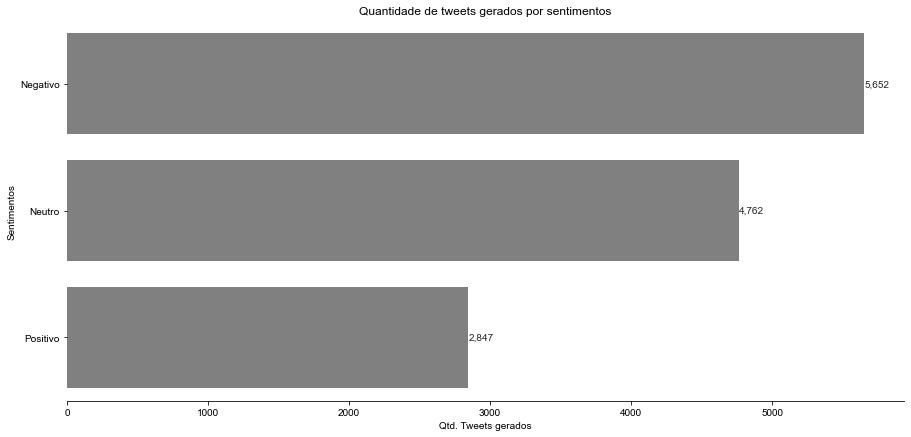

In [51]:
# Gráfico LexiconPT
df_sent=pd.DataFrame(df_polaridade.groupby(by=df_polaridade['sentimento'])['id'].count()).reset_index(level=0).sort_values(by='id', ascending=False)
plt.subplots(figsize=(15, 7))
ax=sns.barplot(data=df_sent, x='id', y='sentimento', color='gray')
sns.set_style('darkgrid')
sns.despine(left=True,bottom=False)
ax.set(xlabel='Qtd. Tweets gerados', ylabel='Sentimentos', title='Quantidade de tweets gerados por sentimentos')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
plt.show()

### Análise dos Sentimentos

In [18]:
pd.set_option('display.max_colwidth', None)
# Classificação:
df['sentiment_pred_soft']=(df['sentiment_pred_nb']+df['sentiment_pred_rl']+df['sentiment_pred_svm'])/3
df['sentiment_pred_soft_desc'] = 'Neutro'
df['sentiment_pred_soft_desc']=np.where(df['sentiment_pred_soft'] < 0, 'Negativo', df['sentiment_pred_soft_desc'])
df['sentiment_pred_soft_desc']=np.where(df['sentiment_pred_soft'] > 0, 'Positivo', df['sentiment_pred_soft_desc'])
df_sent_desc=pd.DataFrame(df.groupby(by=df['sentiment_pred_soft_desc'])['id'].count()).reset_index(level=0).sort_values(by='id', ascending=False)
df_sent_desc.head()

,sentiment_pred_soft_desc,id
0,Negativo,8673
1,Neutro,3240
2,Positivo,668


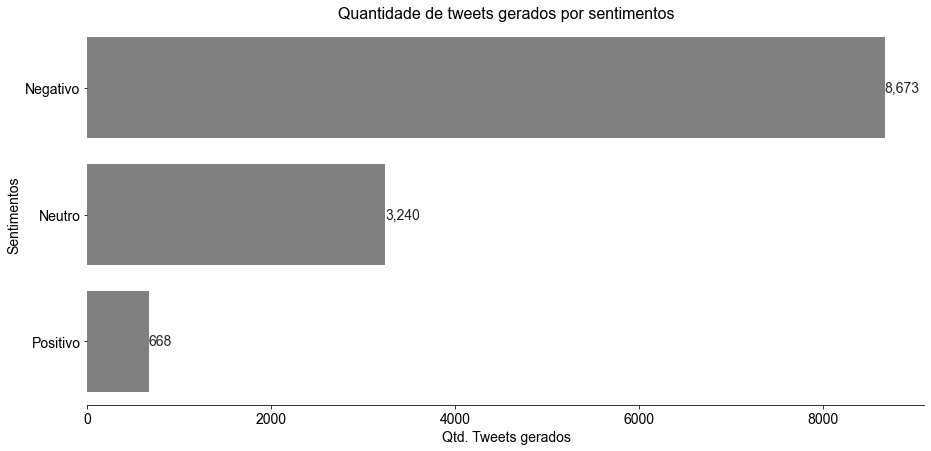

In [19]:
# Tweets x Sentimentos
df_sent=pd.DataFrame(df.groupby(by=df['sentiment_pred_soft_desc'])['id'].count()).reset_index(level=0).sort_values(by='id', ascending=False)
plt.subplots(figsize=(15, 7))
ax=sns.barplot(data=df_sent, x='id', y='sentiment_pred_soft_desc', color='gray')
sns.set_style('darkgrid')
sns.despine(left=True,bottom=False)
ax.set_xlabel('Qtd. Tweets gerados', fontsize=14)
ax.set_ylabel('Sentimentos', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Quantidade de tweets gerados por sentimentos', fontsize=16)
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues], fontsize=14)
plt.savefig(os.path.join(IMAGES_PATH, 'sentimento-qtd-soft.png'), bbox_inches='tight', pad_inches = 0)
plt.show()

In [64]:
# Montagem do dataframe com os sentimentos mais comuns:
def most_common():
    for s in df[['sentiment_pred_nb','sentiment_pred_rl','sentiment_pred_svm']].to_numpy():
        k, v = Counter(s).most_common(1)[0] 
        yield 0 if v == 1 else k
df['sentiment_pred_hard'] = list(most_common())
df['sentiment_pred_hard_desc'] = 'Neutro'
df['sentiment_pred_hard_desc'] = np.where(df['sentiment_pred_hard'] > 0, 'Positivo', df['sentiment_pred_hard_desc'])
df['sentiment_pred_hard_desc'] = np.where(df['sentiment_pred_hard'] < 0, 'Negativo', df['sentiment_pred_hard_desc'])

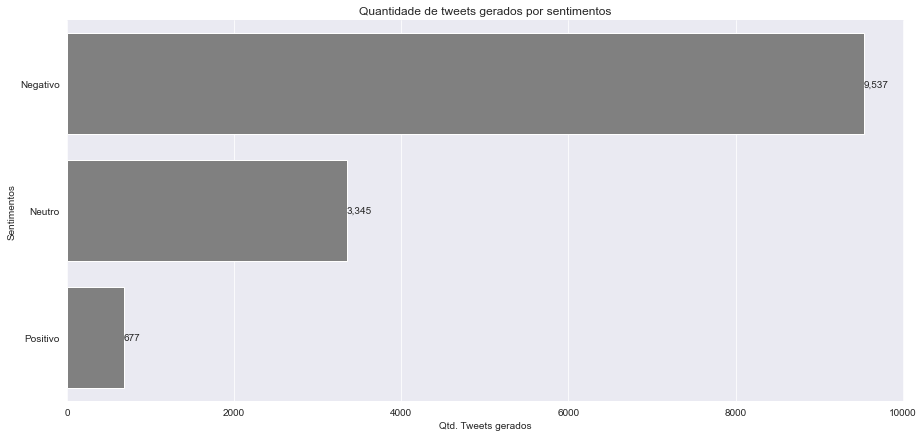

In [65]:
# Gráfico:
df_total=pd.DataFrame(df.groupby(by=df['sentiment_pred_soft_desc'])['id'].count()).reset_index(level=0).sort_values(by='id', ascending=False)
plt.subplots(figsize=(15, 7))
ax=sns.barplot(data=df_total, x='id', y='sentiment_pred_soft_desc', color='gray')
sns.set_style('darkgrid')
sns.despine(left=True,bottom=False)
ax.set(xlabel='Qtd. Tweets gerados', ylabel='Sentimentos', title='Quantidade de tweets gerados por sentimentos')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
plt.savefig(os.path.join(IMAGES_PATH, 'sentimento-qtd-hard.png'))
plt.show()

In [20]:
# Exemplos de Tweets Negativo:
pd.set_option('display.max_colwidth', None)
df[df['sentiment_pred_soft_desc'] == 'Negativo'][['text','sentiment_pred_soft_desc']].head(10)

,text,sentiment_pred_soft_desc
2,A coelba tá doidinha para me dar um PC novo... toda hora cai energia nessa cidade,Negativo
3,Mais de 8 horas sem energia é a porra dessa coelba não ajeitou vai pro inferno,Negativo
5,pelo amor de deus coelba me ajuda,Negativo
6,"@hebernelas Vai dar certo, irmão! Foi a meta que eu botei quando vi um amigo com o crachá da COELBA… Deu certo! 🙏🏽",Negativo
7,QUE INFERNO COELBA,Negativo
8,"maluco se vc passar la na coelba dps das 16:30, eh 100% de certeza que vou estar fazendo alguma maluquice",Negativo
11,Partiu esperar na fila da coelba 🤦🏻‍♀️,Negativo
15,o corno do vagabundo da coelba cortou a luz da rua toda na hora do meu banho 😠😠😠,Negativo
18,"""Eu sou de energia, que energia ruim, capto energias"" trabalha na coelba, tu acha que tem energia PIOR DO QUE A TUA FIA?",Negativo
22,Mesmo após dois meses de reclamações Coelba não resolve problema na Vila de Atalaia https://t.co/2a3My20AaO,Negativo


In [67]:
# Exemplos de Tweets Neutro:
pd.set_option('display.max_colwidth', None)
df[df['sentiment_pred_soft_desc'] == 'Neutro'][['text','sentiment_pred_soft_desc']].head(20)

,text,sentiment_pred_soft_desc
0,OBRA COELBA EM ONDINA PARECE ROMANCE DE JORGE AMADO: OBRA DO SEM FIM #Política https://t.co/OBlc9zLbCI,Neutro
4,Obra da Coelba em Ondina é uma vergonha e a Neoenergia não faria isso na Espanha https://t.co/Qu03fd9MWV,Neutro
9,@liviazord Chegar atrasado na aula pq tava na embasa e na coelba 🤡,Neutro
10,"@cansadaprof E eu com meu prêmio da mostra de pesquisa do HGCA, mas a coelba e o senhorio não aceitam rs",Neutro
12,PARCERIA ENTRE PREFEITURA DE ILHÉUS E COELBA DISPONIBILIZA LÂMPADAS DE LED PARA POPULAÇÃO https://t.co/lMAnUSytOS,Neutro
13,@Masbyyy quando eu passei de onibus na frente e vi tudo apagado jka entrei em depressao\nalso tinha um caminhao da coelba la,Neutro
17,Rating Update for Companhia de Eletricidade do Estado da Bahia Coelba $CEEB3 https://t.co/7KApBrSIsY,Neutro
19,Parceria entre Prefeitura de Ilhéus e Coelba disponibiliza lâmpadas de LED para população\nhttps://t.co/YgzPCVVNte,Neutro
20,@sassivis eu pergunto logo se é sócio da coelba kkkkk raiva,Neutro
21,"RT @opretotaonn: Eu fico imaginando quando vejo passando (coelba, embasa, promotores de cervejas) cada surpresa que deve existir por trás d…",Neutro


In [21]:
# Exemplos de Tweets Positivo:
pd.set_option('display.max_colwidth', None)
df[df['sentiment_pred_soft_desc'] == 'Positivo'][['text','sentiment_pred_soft_desc']].head(50)

,text,sentiment_pred_soft_desc
1,O q a Coelba faz em Ondina pela terceira vez no mesmo lugar? https://t.co/JiZ02iJ6zl,Positivo
14,"@euholandinha @christiandemelo coelba, Nathalia, por gentileza com quem falo?",Positivo
16,"Confira em nosso portal: \nEmpresas e consumidores podem ajudar a OSID através do Projeto Vale Luz, da Neoenergia Coelba https://t.co/VkupKOHpbo https://t.co/uIT6a4t4B0",Positivo
34,"Empresas e consumidores podem ajudar a OSID através do Projeto Vale Luz, da Neoenergia Coelba\nhttps://t.co/Om633niFof https://t.co/XrqwK1B8qJ",Positivo
73,Por que compaixão não paga coelba nem embasa,Positivo
102,RT @marcelleal: Coelba automatizou 150 mil km de rede - Jornal A Regiao - https://t.co/GYbyr64gQx via @Shareaholic https://t.co/CndZwvp0…,Positivo
103,RT @marcelleal: Coelba automatizou 150 mil km de rede - Jornal A Regiao - https://t.co/GYbyr64gQx via @Shareaholic https://t.co/CndZwvp0…,Positivo
104,Coelba automatizou 150 mil km de rede - Jornal A Regiao - https://t.co/GYbyr64gQx via @Shareaholic https://t.co/CndZwvp0cj,Positivo
106,"Investimento: 66 mil reais\nCapacidade real: 1800 kWh (90% performance)\nCapacidade nominal: 1923 kWh\n\nCom a geração dos valores acima irei distribuir para um total de 4 imóveis (1 da geradora e outras 3), todas residências no mesmo estado (Bahia) e distribuidora Coelba/Neoenergia",Positivo
136,RT @marcelleal: Coelba e Senai capacitam eletricistas - Jornal A Regiao - https://t.co/g6B1ZyiEgC via @Shareaholic https://t.co/naKQBjkF…,Positivo


In [ ]:
# Nuvem de palavras sentimentos positivos:
words_cloud = ' '.join([word for word in df[df['sentiment_pred_soft_desc'] == 'Positivo']['text_token']])
print_wordcloud(30,words_cloud,'sentimentos_positivo')

In [ ]:
# Nuvem de palavras sentimentos negativos:
words_cloud = ' '.join([word for word in df[df['sentiment_pred_soft_desc'] == 'Negativo']['text_token']])
print_wordcloud(30,words_cloud,'sentimentos_negativos')

In [ ]:
# Nuvem de palavras sentimentos Neutros:
words_cloud = ' '.join([word for word in df[df['sentiment_pred_soft_desc'] == 'Neutro']['text_token']])
print_wordcloud(30,words_cloud,'sentimentos_Neutros')

In [ ]:
# Quantidade de palavras por sentimento:
df_sent_qtd=df[['sentiment_pred_soft_desc','word_count']].reset_index(level=0)
plt.subplots(figsize=(10, 5))
sns.set_style('darkgrid')
ax=sns.boxplot(x='sentiment_pred_soft_desc', y='word_count', data=df_sent_qtd, color='gray')
ax.set(xlabel='Sentimento', ylabel='Qtd. de palavras no tweet', title='Quantidade de palavras no tweet por sentimento')
plt.savefig(os.path.join(IMAGES_PATH, 'sentimento-qtd-palavras.png'))
plt.show()

In [ ]:
words_cloud = ' '.join([word for word in df[df['sentiment_pred_soft_desc'] == 'Positivo']['tag_token']])
print_wordcloud(30,words_cloud,'tag_positiva')

In [ ]:
# Sentimentos por hora do dia:
df_sent_dt=df[['created_at','sentiment_pred_soft_desc','id']].reset_index()
df_sent_dt['hour']=df_sent_dt['created_at'].dt.hour
df_sent_dt=pd.DataFrame(df_sent_dt.groupby(by=['hour','sentiment_pred_soft_desc'])['id'].count()).reset_index()
df_sent_dt['perc'] = df_sent_dt['id'] / df_sent_dt.groupby('hour')['id'].transform('sum')*100
df_transpose = df_sent_dt.pivot_table('perc',['hour'], 'sentiment_pred_soft_desc').reset_index()
ax=df_transpose.plot(
    x = 'hour', 
    kind = 'bar', stacked = True, 
    figsize=(15,5), grid = True, 
    color=['red','yellow','green'])
ax.set_xlabel('Hora do dia', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel('% dos Tweets', fontsize=14)
ax.set_title('Sentimentos dos tweets por hora do dia', fontsize=16)
plt.grid()
plt.legend(['Negativo','Neutro','Positivo'], title = 'Sentimento', loc='lower right', prop={'size': 12} )
plt.savefig(os.path.join(IMAGES_PATH, 'sentimentos-hora-do-dia.png'), bbox_inches='tight', pad_inches = 0)

In [ ]:
df_sent_dt[df_sent_dt['sentiment_pred_soft_desc'] == 'Positivo'].sort_values(by='perc',ascending=False).head(15)

In [ ]:
# Sentimentos por local:
df_sent_loc=df[df['city_name'].notnull()][['text','city_name','sentiment_pred_soft_desc','id']]
df_sent_loc=pd.DataFrame(df_sent_loc.groupby(by=['city_name','sentiment_pred_soft_desc'])['id'].count()).reset_index()
df_sent_loc['perc'] = df_sent_loc['id'] / df_sent_loc.groupby('city_name')['id'].transform('sum')*100
df_transpose = df_sent_loc.pivot_table('perc',['city_name'], 'sentiment_pred_soft_desc').reset_index()
print('Tweets classificados nas cidades:')
print(df_sent_loc.groupby(by=['sentiment_pred_soft_desc'])['id'].sum())

In [ ]:
print('Cidades mais negativas:')
print(df_sent_loc[df_sent_loc['sentiment_pred_soft_desc'] == 'Negativo'].sort_values(by='id', ascending=False).head())
qtd = df_sent_loc[df_sent_loc['sentiment_pred_soft_desc'] == 'Negativo']['city_name'].count()
print(f'Cidades com comentários negativos: {qtd}')
qtd = df_sent_loc[(df_sent_loc['perc'] == 100) & (df_sent_loc['sentiment_pred_soft_desc'] == 'Negativo')]['city_name'].count()
print(f'Cidades 100% negativas: {qtd}')
print()
print('Cidades mais positivas:')
print(df_sent_loc[df_sent_loc['sentiment_pred_soft_desc'] == 'Positivo'].sort_values(by='id', ascending=False).head())
qtd = df_sent_loc[df_sent_loc['sentiment_pred_soft_desc'] == 'Positivo']['city_name'].count()
print(f'Cidades com comentários positivos: {qtd}')
qtd = df_sent_loc[(df_sent_loc['perc'] == 100) & (df_sent_loc['sentiment_pred_soft_desc'] == 'Positivo')]['city_name'].count()
print(f'Cidades 100% positivas: {qtd}')
print()
print('Cidades mais neutras:')
print(df_sent_loc[df_sent_loc['sentiment_pred_soft_desc'] == 'Neutro'].sort_values(by='id', ascending=False).head())
qtd = df_sent_loc[df_sent_loc['sentiment_pred_soft_desc'] == 'Neutro']['city_name'].count()
print(f'Cidades com comentários neutros: {qtd}')
qtd = df_sent_loc[(df_sent_loc['perc'] == 100) & (df_sent_loc['sentiment_pred_soft_desc'] == 'Neutro')]['city_name'].count()
print(f'Cidades 100% neutras: {qtd}')


In [ ]:
df_weekday=pd.DataFrame({'weekday':[0,1,2,3,4,5,6], 'name':['Segunda-Feira','Terça-Feira','Quarta-Feira','Quinta-Feira','Sexta-Feira','Sábado','Domingo']})
#df_dt=pd.DataFrame(df.groupby(by=df['created_at'].dt.dayofweek)['id'].count()).reset_index(level=0).rename(columns={'created_at':'weekday','id':'qtd'})
#df_dt=pd.merge(df_dt, df_weekday, how='left', on='weekday')

# Sentimentos por dia da semana:
df_sent_dt=df[['created_at','sentiment_pred_soft_desc','id']].reset_index()
df_sent_dt['weekday']=df_sent_dt['created_at'].dt.dayofweek
df_sent_dt=pd.merge(df_sent_dt, df_weekday, how='left', on='weekday')
df_sent_dt_res=pd.DataFrame(df_sent_dt.groupby(by=['name','weekday','sentiment_pred_soft_desc'])['id'].count()).reset_index()
df_sent_dt_res['perc'] = df_sent_dt_res['id'] / df_sent_dt_res.groupby('name')['id'].transform('sum')*100
df_sent_dt_res=df_sent_dt_res.sort_values(by='weekday')
df_transpose = df_sent_dt_res.pivot_table('perc',['name'], 'sentiment_pred_soft_desc').reset_index()
print('Dias mais negativos:')
print(df_sent_dt_res[df_sent_dt_res['sentiment_pred_soft_desc'] == 'Negativo'].sort_values(by='perc', ascending=False).head(7))
print('Dias mais positivos:')
print(df_sent_dt_res[df_sent_dt_res['sentiment_pred_soft_desc'] == 'Positivo'].sort_values(by='perc', ascending=False).head(7))
print('Dias mais neutros:')
print(df_sent_dt_res[df_sent_dt_res['sentiment_pred_soft_desc'] == 'Neutro'].sort_values(by='perc', ascending=False).head(7))

## Tópicos dos Tweets:

### Testes de modelos

In [22]:
#Variáveis dos Modelos:
n_folds=30 #Número de folds
cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=5, random_state=1) #Geração do KFold
scoring='accuracy' #Métrica de avaliação principal

In [23]:
# Funções:
def metricas(teste,predito):
    nome={}
    acc=metrics.accuracy_score(teste,predito)
    mcc=metrics.matthews_corrcoef(teste,predito)
    r=metrics.recall_score(teste,predito,average='macro')
    p=metrics.precision_score(teste,predito,average='macro')
    f1=metrics.f1_score(teste,predito,average='macro')
    nome = dict(zip(['acc','mcc','r','p','f1'], [acc,mcc,r,p,f1]))
    return nome

def mc(teste,predito):
    confusion_matrix = pd.crosstab(teste, predito, rownames=['Real'], colnames=['Predito'])
    return confusion_matrix

In [24]:
import warnings
warnings.filterwarnings("ignore")
# Avaliação dos modelos com os conjuntos de treino:
models = []
results = []
names = []
models.append(('Naive Bayes TF', MultinomialNB(), TfidfVectorizer()))
models.append(('Naive Bayes Vetor', MultinomialNB(), CountVectorizer(analyzer='word')))
models.append(('Logistic Regression TF', LogisticRegression(solver='lbfgs'), TfidfVectorizer()))
models.append(('Logistic Regression Vetor', LogisticRegression(solver='lbfgs'), CountVectorizer(analyzer='word')))
models.append(('RandomForest TF', RandomForestClassifier(), TfidfVectorizer()))
models.append(('RandomForest Vetor', RandomForestClassifier(), CountVectorizer(analyzer='word')))
models.append(('SVM TF', SVC(), TfidfVectorizer()))
models.append(('SVM Vetor', SVC(), CountVectorizer(analyzer='word')))

print('Tweets tratados:')
for name, model, vector in models:
    text_counts = vector.fit_transform(df_classificacao['text_token'])
    x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['topic_class'],test_size=0.3,random_state=1)
    cv_results = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

print()
print('Tweets sem tratamento:')
for name, model, vector in models:
    text_counts = vector.fit_transform(df_classificacao['text_process'])
    x_train,x_test,y_train,y_test=train_test_split(text_counts,df_classificacao['topic_class'],test_size=0.3,random_state=1)
    cv_results = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Tweets tratados:
Naive Bayes TF: 0.570635 (0.080674)
Naive Bayes Vetor: 0.694508 (0.108777)
Logistic Regression TF: 0.575587 (0.082994)
Logistic Regression Vetor: 0.695651 (0.099291)
RandomForest TF: 0.666254 (0.094716)
RandomForest Vetor: 0.672635 (0.100824)
SVM TF: 0.503365 (0.064168)
SVM Vetor: 0.621619 (0.088506)

Tweets sem tratamento:
Naive Bayes TF: 0.543048 (0.062729)
Naive Bayes Vetor: 0.737333 (0.101630)
Logistic Regression TF: 0.612857 (0.076785)
Logistic Regression Vetor: 0.704698 (0.108330)
RandomForest TF: 0.654921 (0.090801)
RandomForest Vetor: 0.669175 (0.092151)
SVM TF: 0.545302 (0.069797)
SVM Vetor: 0.643397 (0.095004)


In [35]:
# Regressão Logística - Sem tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_process'],df_classificacao['topic_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer(analyzer='word')),('tfidf', TfidfTransformer()),('clf', LogisticRegression())])

# Auto-tuning
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.arange(0, 200, 20), 
    'clf__penalty': ['l1', 'l2', None],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']
 }
gs_clf = GridSearchCV(text_clf, param_grid=parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 

gs_predicted = gs_clf.predict(x_test)
rl_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(rl_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

In [ ]:
# Regressão Logística - Com tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_token'],df_classificacao['topic_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer(analyzer='word')),('tfidf', TfidfTransformer()),('clf', LogisticRegression())])

# Auto-tuning
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.arange(0, 200, 20),, 
    'clf__penalty': ['l1', 'l2', None],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']
 }
gs_clf = GridSearchCV(text_clf, param_grid=parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 
      
gs_predicted = gs_clf.predict(x_test)
rl_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(rl_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

In [18]:
import warnings
warnings.filterwarnings("ignore")
# Naive Bayes - Sem tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_process'],df_classificacao['topic_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

# Auto-tuning
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__fit_prior': (True, False),
              'clf__alpha': np.arange(0, 2, 0.05)}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 

gs_predicted = gs_clf.predict(x_test)
nb_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(nb_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

Métricas:
{'acc': 0.6631578947368421, 'mcc': 0.5142566534341729, 'r': 0.4744175084175084, 'p': 0.5031261000397433, 'f1': 0.45566646175250713}
Melhores parâmetros:
{'clf__alpha': 0.05, 'clf__fit_prior': True, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}


In [19]:
# Naive Bayes - Com tratamento nos tweets
x_train,x_test,y_train,y_test=train_test_split(df_classificacao['text_token'],df_classificacao['topic_class'],test_size=0.3,random_state=1)
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

# Auto-tuning
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__fit_prior': (True, False),
              'clf__alpha':   np.arange(0, 2, 0.05)}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=cv)
gs_clf.fit(x_train,y_train) 

gs_predicted = gs_clf.predict(x_test)
nb_tunned = metricas(y_test,gs_predicted)
print('Métricas:')
print(nb_tunned)

print('Melhores parâmetros:')
print(gs_clf.best_params_)

Métricas:
{'acc': 0.6684210526315789, 'mcc': 0.5236956541594984, 'r': 0.4797800224466891, 'p': 0.5298901098901099, 'f1': 0.46821578204710734}
Melhores parâmetros:
{'clf__alpha': 0.2, 'clf__fit_prior': True, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
